<a href="https://colab.research.google.com/github/Lucalangella/tennis-court-classifier/blob/main/notebooks/train_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- BLOCK 1: INSTALL DEPENDENCIES & FIX RUNTIME ---
import os
import time

print("1. Installing compatible libraries...")
# limit output with -qq
!pip install -Uqq "numpy<2" fastai==2.7.14 fastprogress==1.0.3 coremltools

# Check if we need to restart
try:
    import numpy
    # If numpy is loaded and is version 2+, we MUST restart
    if numpy.__version__.startswith('2'):
        print("⚠️ Incompatible NumPy detected. Restarting runtime automatically...")
        print("⏳ Please wait for the runtime to reconnect, then RUN BLOCK 2.")
        time.sleep(1) # Give the print statement time to show
        os.kill(os.getpid(), 9)
    else:
        print("✅ Environment is ready! You can proceed to Block 2.")
except ImportError:
    print("✅ Environment is ready! You can proceed to Block 2.")

1. Installing compatible libraries...
✅ Environment is ready! You can proceed to Block 2.


In [2]:
# --- BLOCK 2: CLONE DATA & SETUP PATHS ---
import shutil
from pathlib import Path
from fastai.vision.all import *

# 1. Clean up old runs (to ensure we pull fresh data)
repo_name = "tennis-court-classifier"
if os.path.exists(repo_name):
    shutil.rmtree(repo_name)

# 2. Clone the repository
user = "LucaLangella"
print(f"Cloning repository from user: {user}...")
!git clone https://github.com/{user}/{repo_name}.git

# 3. Define path
path = Path(f'./{repo_name}/tennis_courts')

# 4. Verify
if path.exists():
    print(f"✅ Setup complete. Data path set to: {path}")
    print(f"   Found {len(get_image_files(path))} images.")
else:
    print("❌ Error: Data folder not found. Check the repository name.")

Cloning repository from user: LucaLangella...
Cloning into 'tennis-court-classifier'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 264 (delta 8), reused 0 (delta 0), pack-reused 245 (from 2)
Receiving objects: 100% (264/264), 191.42 MiB | 25.97 MiB/s, done.
Resolving deltas: 100% (26/26), done.
✅ Setup complete. Data path set to: tennis-court-classifier/tennis_courts
   Found 155 images.


In [3]:
# --- BLOCK 3: VERSION VERIFICATION ---
import numpy
import fastai
import coremltools

print(f"✅ NumPy Version: {numpy.__version__}")
# Target Version: 1.26.x (Must be below 2.0)

print(f"✅ FastAI Version: {fastai.__version__}")
# Target Version: 2.7.14

print("Refinding your data...")
from fastai.vision.all import *
path = Path('./tennis-court-classifier/tennis_courts')

if path.exists():
    print(f"✅ Data still there! Found {len(get_image_files(path))} images.")
else:
    print("⚠️ Data was wiped by the restart. Please Run 'Block 1' again (The Setup Block).")

✅ NumPy Version: 1.26.4
✅ FastAI Version: 2.7.14
Refinding your data...
✅ Data still there! Found 155 images.


In [4]:
# --- BLOCK 4: DATASET AUGMENTATION (UNKNOWN CLASS) ---
from fastai.vision.all import *

# 1. Create the directory for the 'unknown' category
unknown_folder = path / 'unknown'
unknown_folder.mkdir(parents=True, exist_ok=True)

# 2. Check folder content and populate with noise data if empty
if len(get_image_files(unknown_folder)) < 10:
    print("⚠️ 'Unknown' folder is empty. Downloading junk images...")

    # Download Imagenette (a dataset of random objects)
    path_random = untar_data(URLs.IMAGENETTE_160)

    # Transfer 50 random images to serve as negative examples
    random_files = get_image_files(path_random/'train')[:50]
    for i, file in enumerate(random_files):
        shutil.copy(file, unknown_folder / f'random_{i}.jpg')

    print(f"✅ Added {len(random_files)} images to 'unknown' folder.")
else:
    print(f"✅ 'Unknown' folder already has {len(get_image_files(unknown_folder))} images.")

✅ 'Unknown' folder already has 50 images.


In [5]:
# --- BLOCK 5: MODEL TRAINING ---
# 1. Initialize DataLoaders with resizing and augmentation
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224, method='squish'),
    batch_tfms=aug_transforms(mult=1.5),
    bs=32,
    num_workers=2
)

print(f"Classes found: {dls.vocab}")
# Verification: Expecting ['clay', 'grass', 'hard', 'unknown']

# 2. Instantiate the Convolutional Neural Network (ResNet18)
learn = vision_learner(dls, resnet18, metrics=error_rate)

# 3. Execute training loop
print("\nStarting training...")
# Note: Ensure this line executes without indentation errors
learn.fine_tune(4)

print("✅ Training complete!")

Classes found: ['clay', 'grass', 'hard', 'unknown']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]



Starting training...


epoch,train_loss,valid_loss,error_rate,time
0,2.096509,1.212377,0.419355,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.125463,0.770762,0.258065,00:16
1,1.043088,0.589969,0.225806,00:14
2,0.819539,0.450047,0.193548,00:16
3,0.653781,0.378528,0.193548,00:14


✅ Training complete!


Displaying predictions (Green = Correct, Red = Mistake)...


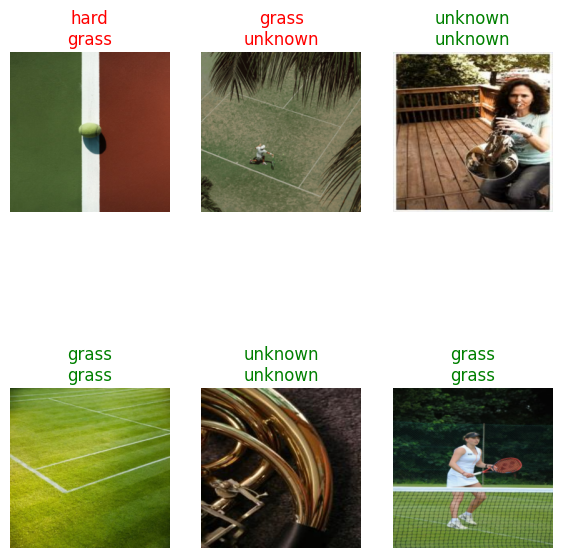

In [6]:
# --- BLOCK 6: PREDICTION VISUALIZATION ---
# Display sample predictions from the validation set
# Format: Label = Actual Class / Prediction = Model Output
print("Displaying predictions (Green = Correct, Red = Mistake)...")
learn.show_results(max_n=6, figsize=(7, 8))

In [7]:
# --- BLOCK 7: EXTERNAL VALIDATION (TEST SET) ---
import os
from fastai.vision.all import *

# 1. Define path to the separate test dataset
repo_name = "tennis-court-classifier"
test_path = Path(f'./{repo_name}/test_images_set')

# 2. Verify existence of test files
if test_path.exists():
    files_found = get_image_files(test_path)
    print(f"✅ FOUND TEST SET: {len(files_found)} images")

    # 3. Generate predictions on test data
    print("\n--- GRADING YOUR MODEL ---")

    test_dl = learn.dls.test_dl(files_found)
    preds, _ = learn.get_preds(dl=test_dl)

    for i, file in enumerate(files_found):
        predicted_index = preds[i].argmax()
        predicted_label = dls.vocab[predicted_index]
        confidence = preds[i][predicted_index] * 100

        flag = "⚠️" if confidence < 60 else "✅"
        print(f"{flag} File: {file.name.ljust(20)} --> Predicted: {predicted_label.upper().ljust(10)} ({confidence:.1f}%)")

else:
    print(f"❌ ERROR: Could not find folder at {test_path}")
    print("You may need to run 'Block 1' again to re-download the updated repo.")

✅ FOUND TEST SET: 17 images

--- GRADING YOUR MODEL ---


✅ File: test_clay_1.png      --> Predicted: CLAY       (62.3%)
✅ File: test_clay_2.png      --> Predicted: CLAY       (85.5%)
✅ File: test_random_9.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_hard_3.png      --> Predicted: CLAY       (93.2%)
✅ File: test_random_5.jpg    --> Predicted: UNKNOWN    (99.2%)
✅ File: test_random_7.jpg    --> Predicted: UNKNOWN    (99.6%)
✅ File: test_random_3.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_random_6.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_random_8.jpg    --> Predicted: UNKNOWN    (95.9%)
✅ File: test_clay_3.png      --> Predicted: CLAY       (92.2%)
✅ File: test_random_2.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_hard_1.png      --> Predicted: CLAY       (74.0%)
✅ File: test_random_1.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_hard_2.png      --> Predicted: HARD       (87.5%)
✅ File: test_random_0.jpg    --> Predicted: UNKNOWN    (100.0%)
⚠️ File: test_grass_1.png     --> Predicted: GRAS

Generating Confusion Matrix...



Top 5 Biggest Mistakes:


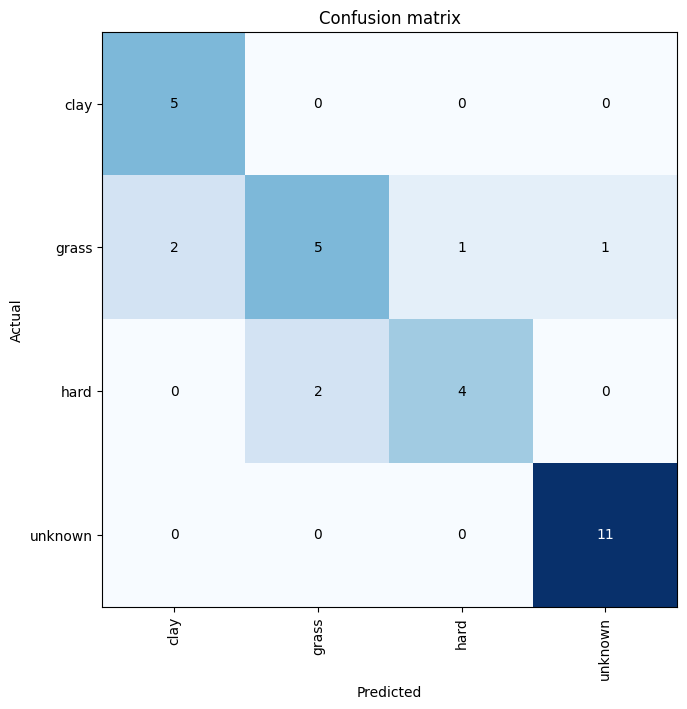

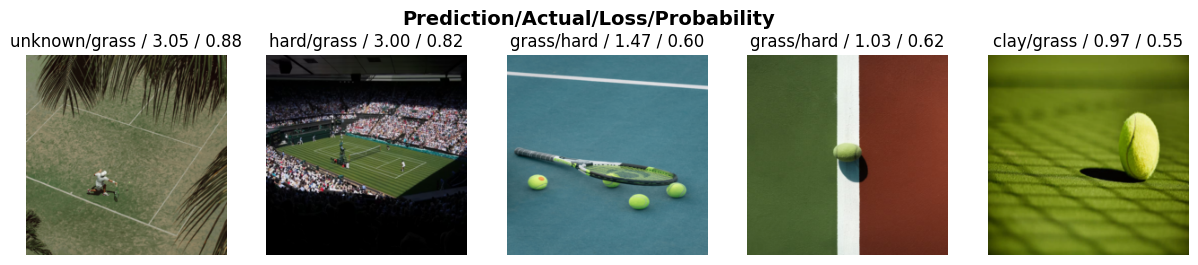

In [8]:
# --- BLOCK 8: ERROR ANALYSIS ---
from fastai.vision.all import *

# 1. Initialize Classification Interpretation
interp = ClassificationInterpretation.from_learner(learn)

# 2. Generate and display the Confusion Matrix
print("Generating Confusion Matrix...")
interp.plot_confusion_matrix(figsize=(7, 7))

# 3. Visualize the top 5 most confident incorrect predictions
print("\nTop 5 Biggest Mistakes:")
interp.plot_top_losses(5, nrows=1)

In [9]:
# --- BLOCK 9: MANUAL INFERENCE WIDGET ---
import ipywidgets as widgets
from PIL import Image
import io

# 1. Initialize file upload widget and output display
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_data_change(change):
    lbl_pred.value = ''

    # Process the uploaded image
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))

    # Run inference
    pred, pred_idx, probs = learn.predict(img)

    # Update label with result
    lbl_pred.value = f'PREDICTION: {pred.upper()} (Confidence: {probs[pred_idx]*100:.2f}%)'

# Bind the event handler
btn_upload.observe(on_data_change, names=['data'])

# Render the UI
print("Click 'Upload' to test a new image:")
display(widgets.VBox([btn_upload, out_pl, lbl_pred]))

Click 'Upload' to test a new image:


In [10]:
# --- BLOCK 10: COREML EXPORT ---
import coremltools as ct
import torch
from google.colab import files

print("Converting model to CoreML...")

# 1. Switch model to CPU evaluation mode for tracing
model = learn.model.eval().cpu()
dummy_input = torch.rand(1, 3, 224, 224)
traced_model = torch.jit.trace(model, dummy_input)

# 2. Convert PyTorch trace to CoreML format with ImageNet normalization
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(
        name="image",
        shape=dummy_input.shape,
        scale=1/255.0,
        bias=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
    )],
    classifier_config=ct.ClassifierConfig(list(dls.vocab))
)

# 3. Add metadata and compress the artifact
mlmodel.short_description = "Tennis Court Classifier"
mlmodel.author = "Luca"
save_name = "TennisClassifier_Colab.mlpackage"
mlmodel.save(save_name)

print("✅ Model saved! Zipping...")
zip_name = "TennisClassifier_Final"
shutil.make_archive(zip_name, 'zip', save_name)

# 4. Trigger file download
print("⬇️ Downloading file...")
files.download(f"{zip_name}.zip")

Converting model to CoreML...


Running MIL default pipeline:   0%|          | 0/95 [00:00<?, ? passes/s]/usr/local/lib/python3.12/dist-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '358', of the source model, has been renamed to 'var_358' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 308.09 passes/s]


✅ Model saved! Zipping...
⬇️ Downloading file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>